In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/gans/

/content/drive/MyDrive/gans


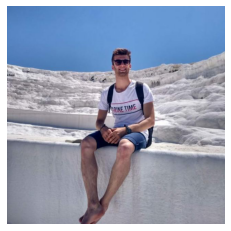

In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = "pp.jpg"

plt.axis("off")
plt.imshow(keras.preprocessing.image.load_img(base_image_path))

In [4]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [61]:
layer_settings = {
    "mixed7": 1.5,
    "mixed8":1.5,
    "mixed5":1.0,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [62]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [63]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [64]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 20.


In [65]:
import numpy as np

def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [66]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img("dream.png", deprocess_image(img.numpy()))


Processing octave 0 with shape (326, 326)
... Loss value at step 0: 0.77
... Loss value at step 1: 0.99
... Loss value at step 2: 1.45
... Loss value at step 3: 1.72
... Loss value at step 4: 2.36
... Loss value at step 5: 3.02
... Loss value at step 6: 3.82
... Loss value at step 7: 4.78
... Loss value at step 8: 5.41
... Loss value at step 9: 6.10
... Loss value at step 10: 6.03
... Loss value at step 11: 5.85
... Loss value at step 12: 8.50
... Loss value at step 13: 8.69
... Loss value at step 14: 9.50
... Loss value at step 15: 11.41
... Loss value at step 16: 12.83
... Loss value at step 17: 12.82
... Loss value at step 18: 15.81
... Loss value at step 19: 18.00
... Loss value at step 20: 15.67
... Loss value at step 21: 17.58
... Loss value at step 22: 19.92
... Loss value at step 23: 19.00
Processing octave 1 with shape (457, 457)
... Loss value at step 0: 0.71
... Loss value at step 1: 1.28
... Loss value at step 2: 1.76
... Loss value at step 3: 2.46
... Loss value at step 4: